# SOADML - Incremental methods with second order information

    Authors : Léa Bresson, Charles Dognin
   
The aim of this notebook is to implement and compare the algorithms introduced in 2018 by Gower et al. in the paper "*Tracking the gradients using the Hessian : A new look at variance reducing stochastic methods*". We discuss the efficiency of the algorithms proposed in this paper by benchmarking it against SVRG on a classification and regression problems. 

The following methods are compared :
- Stochastic Variance Reduced Gradient (SVRG),
- SVRG2 that tracks the gradients using the full Hessian,
- 2D, CM and AM that track the gradients using different Hessian approximations (Diagonal approximation via robust secant equation, low-rank Curvature Matching approximation, low-rank Action Matching approximation, respectively). 


First, we consider a logistic regression with ridge penalization using the same dataset as the authors, i.e. the *Gisette* dataset. Then, we consider a least-squares regression with ridge penalization (not implemented by Gower et al.) using the *Cadata* dataset from LIBSVM.

### Table of content
[1. Loss functions and gradients for logistic regression (Gisette dataset)](#dataclassif)<br>
[2. Loss functions and gradients for least-squares regression (Cadata dataset)](#dataregr)<br>
[3. Algorithms](#algo)<br>
[4. Classification case : Numerical comparison](#comp1)<br>
[5. Regression case : Numerical comparison](#comp2)<br>
[6. Conclusions](#conc)<br>




In [1]:
%matplotlib inline

In [2]:
# Package Imports 

import numpy as np
from tqdm import tqdm
#from numba import njit
from scipy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file
from scipy.linalg import svd
from numba import njit

<a id='dataclassif'></a>
## 1. Loss functions and gradients for logistic regression (Gisette dataset)


### Gisette Dataset Pre-Processing

Gisette is a handwritten digit recognition problem inspired by the MINST dataset. The problem is to separate the highly confusable digits '4' and '9'. This is a binary classification problem. The images are size-normalized in a 28 x 28 window. The dataset contains 5000 features and 6000 samples.

In [101]:
def preprocessing_y(filename):
    data = []
    with open(filename) as file:
        for row in file.readlines():
            data.append((row.strip()).split(" "))
    data = np.array(data).astype(int)
    data = np.squeeze(data, axis=1)
    return data

def preprocessing_x(filename):
    data = []
    with open(filename) as file:
        for row in file.readlines():
            data.append((row.strip()).split(" "))
    data = np.array(data).astype(int)
    return data

# Here the shape of x_train is (6000, 5000) = (number of examples, dimension)
x_train_c = preprocessing_x("gisette_train.data") 
y_train_c = preprocessing_y("gisette_train.labels")

### Logistic loss with a squared-$ \ell$2 regularizer


We want to minimize
$$
\frac 1n \sum_{i=1}^n \log(1 + \exp(-y_i X_i^\top \theta)) + \frac \lambda 2 \|\theta\|_2^2  = \frac 1n \sum_{i=1}^n f_i(\theta)
$$

where
$$
f_i(\theta) = \log(1 + \exp(-y_i X_i^\top \theta) + \frac \lambda 2 \|\theta\|_2^2.
$$

The gradient is : 
$$
\nabla f_i(\theta) = - \frac{y_i}{1 + \exp(y_i X_i^\top \theta)} X_i + \lambda \theta.
$$

### Parameter values

#### Stepsize  

Although Gower et al. chose the stepsize through a grid search procedure, we use a theoretical step-size equals to $1 / L$. (reference ??)
Where $L$ the Lipschitz constant of $f$ and $\mathbf X^\top = [X_1, \ldots, X_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for logistic regression it is
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{2}}{4 n} + \lambda.
$$

$ \frac{1}{\max_{i=1,\ldots,n} L_i}$ where $ L_i = \frac 14 \| X_i \|_2^2 + \lambda$    (reference ???)




#### Regularization parameter

The regularization parameter is set to $ \lambda= max_{i=1,…,n} \frac{||X_i||_2^2}{ 4n}$.

In [97]:
# We define the functions used in the optimization part 

class Classification(object):
    """A class for the logistic regression with ridge penalization"""
    
    def __init__(self, x_train, y_train, lbda):
        self.x_train = x_train
        self.y_train = y_train
        self.n, self.d = x_train.shape
        self.lbda = lbda

    def loss(self, theta):
        bAx = self.y_train * np.dot(self.x_train, theta)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * np.linalg.norm(theta) ** 2 / 2.

    def grad(self, theta):
        bAx = self.y_train * np.dot(self.x_train, theta)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.x_train.T, self.y_train * temp) / self.n + self.lbda * theta
        return grad
    
    def grad_i(self, i, theta):
        grad = - self.x_train[i] * self.y_train[i] / (1. + np.exp(self.y_train[i] * np.dot(self.x_train[i], theta)))
        grad += self.lbda * theta
        return grad
    
    def hess(self, theta):
        hess = np.mean([self.hess_i(i, theta) for i in range(self.n)])
        return hess
        
    def hess_i(self, i, theta):
        temp = 1 / (1. + np.exp(self.y_train[i] * np.dot(self.x_train[i], theta))) 
        xy = self.x_train[i] * self.y_train[i] * temp
        hess = np.dot(xy, xy.T) + self.lbda
        return hess  

    def lipschitz_constant(self):
        return np.linalg.norm(self.x_train, ord=2) ** 2 / (4. * self.n) + self.lbda   

<a id='datareg'></a>
## 2. Loss functions and gradients for least-squares regression (Cadata dataset)


### Cadata Dataset Pre-Processing

The California housing dataset (Cadata) contains details related to the housing of the population in a given California district (number of people in a certain area, geographic area, average income, housing average age, average rooms, etc.). The average house value is the target variable.
The dataset contains 8 features and 20640 samples.

In [8]:
x_train , y_train = load_svmlight_file("cadata.txt")

# Here the shape of x_train is (20640, 8) = (dimension, number of examples)
x_train = x_train.toarray()
y_train = y_train.reshape((y_train.size, 1))

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
x_train_r = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)
y_train_r = y_train.reshape((y_train.size,))

### Least-Square loss with $\ell_2$ regularizer

We want to minimize
$$
\frac 1n \sum_{i=1}^n \frac 12 (y_i - X_i^\top \theta)^2 + \frac \lambda 2 \|\theta\|_2^2 = \frac 1n \sum_{i=1}^n f_i(\theta)
$$

where
$$
f_i(\theta) = \frac 12 (y_i - X_i^\top \theta)^2  + \frac \lambda 2 \|\theta\|_2^2.
$$

The gradient is
$$
\nabla f_i(\theta) = (X_i^\top \theta - y_i) X_i + \lambda \theta
$$

The hessian is
$$
H_i(\theta) = X_i {X_i}^{T} + \lambda I
$$

### Parameter values

#### Stepsize  ( à voir ????????????)

Although Gower et al. chose the stepsize through a grid search procedure, we use a theoretical step-size equals to $1 / L$. (reference ??)
Where $L$ the Lipschitz constant of $f$ and $\mathbf X^\top = [X_1, \ldots, X_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for logistic regression it is
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| X_i \|_2^2 + \lambda
$$

##### ???? ou 
$ \frac{1}{\max_{i=1,\ldots,n} L_i}$ where $ L_i = \frac 14 \| X_i \|_2^2 + \lambda$    (reference ???)


#### Regularization parameter

The regularization parameter is set to $ \lambda= max_{i=1,…,n} \frac{||X_i||_2^2}{ 4n}$.



In [152]:
# We define the functions used in the optimization part 

class Regression(object):
    """A class for the least-squares regression with ridge penalization"""

    def __init__(self, x_train, y_train, lbda):
        self.x_train = x_train
        self.y_train = y_train
        self.n, self.d = x_train.shape
        self.lbda = lbda

    def grad(self, theta):
        return self.x_train.T.dot(self.x_train.dot(theta) - self.y_train) / self.n + self.lbda * theta

    def loss(self, theta):
        return norm(self.x_train.dot(theta) - self.y_train) ** 2 / (2. * self.n) + self.lbda * norm(theta) ** 2 / 2.

    def grad_i(self, i, theta):
        a_i = self.x_train[i]
        return (a_i.dot(theta) - self.y_train[i]) * a_i + self.lbda * theta
    
    def hess(self, theta=None): 
        hess = np.mean([self.hess_i(i, theta) for i in range(self.n)])
        return hess
    
    def hess_i(self, i, theta=None):
        a_i = self.x_train[i]
        a_i = np.expand_dims(a_i, axis=1)
        hess = np.dot(a_i, a_i.T) + self.lbda
        return hess
        
    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.x_train, ord=2) ** 2 / self.n + self.lbda

In [153]:
print("\033[1mRegression (Cadata Dataset): \033[0m")
n = x_train_r.shape[0]

lbda = np.max(np.sum(x_train_r ** 2, axis=1))  / (4. * n)
lbda = 1. / n ** (0.5)
model = Regression(x_train_r, y_train_r, lbda)

max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
stepsize = 2**2 / (max_squared_sum + lbda) 
svrg_reg = optimize_svrg_2(100, 2 * 100, x_train_r, y_train_r, stepsize, model)

Regression (Cadata Dataset): 
After iteration 10 loss is now:  6.223527731475175
After iteration 20 loss is now:  18010.710995979694
After iteration 30 loss is now:  53886432.37171585
After iteration 40 loss is now:  161225102472.2304
After iteration 50 loss is now:  482376223747306.1


KeyboardInterrupt: 

<a id='algo'></a>
## 3. Algorithms



### SVRG

#### Commentaires (à supp):

- itr2 : doit etre égal à n ou 2*n  => Johnson and Zhang : "Therefore it is natural to choose m to
be the same order of n but slightly larger (for example m = 2n for convex problems and m =
5n for nonconvex problems in our experiments)"

- lambda :lbda = 1. / n ** (0.5) Ou lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n). 

In [107]:
# SVRG

def optimize_svrg(itr1, itr2, x_train, y_train, stepsize, model):
    """Stochastic variance reduction gradient algorithm."""
    
    n = x_train.shape[0]
    d = x_train.shape[1]
    
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    loss_history = []
    
    for k in range(1, itr1+1):
        grad_k =  model.grad(theta_bar)
        theta = theta_bar.copy()
        
        for t in range(itr2):
            i = np.random.randint(0, n) 
            theta = theta - stepsize * (model.grad_i(i, theta) - model.grad_i(i, theta_bar) + grad_k)  
            
        theta_bar = theta
        
        if (k % 10) == 0:
            print("After iteration {} loss is now: ".format(k), model.loss(theta_bar))
            loss_history.append(model.loss(theta_bar))
    plt.plot(loss_history)
    
    return theta_bar

In [128]:
## SVRG2

def optimize_svrg_2(itr1, itr2, x_train, y_train, stepsize, model):
    """Stochastic variance reduction gradient algorithm with second-order tracking."""

    n = x_train.shape[0]
    d = x_train.shape[1]
    
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    loss_history = []
    
    for k in range(1, itr1+1):
        grad_k =  model.grad(theta_bar)
        hess_k = model.hess(theta_bar)
        theta = theta_bar.copy()
        
        for t in range(itr2):
            i = np.random.randint(0, n)
            
            theta = theta - stepsize * (model.grad_i(i, theta) - model.grad_i(i, theta_bar)
                                        - np.dot(model.hess_i(i, theta_bar), theta - theta_bar)
                                        + grad_k)# + np.dot(hess_k, theta - theta_bar))
        theta_bar = theta
        
        if (k % 10) == 0:
            print("After iteration {} loss is now: ".format(k), model.loss(theta_bar))
            loss_history.append(model.loss(theta_bar))    
    plt.plot(loss_history)
        
    return theta_bar

<a id='comp1'></a>
## 4. Classification case : Numerical comparison


<a id='comp1'></a>
### SVRG1


Classification (Gisette Dataset): 
After iteration 10 loss is now:  0.1907201312029001
After iteration 20 loss is now:  0.1888593342195758
After iteration 30 loss is now:  0.18878194374166335
After iteration 40 loss is now:  0.1887781218734355
After iteration 50 loss is now:  0.18877791648807313
After iteration 60 loss is now:  0.1887779048610322
After iteration 70 loss is now:  0.1887779041764561
After iteration 80 loss is now:  0.18877790413516332
After iteration 90 loss is now:  0.18877790413262696
After iteration 100 loss is now:  0.18877790413246875


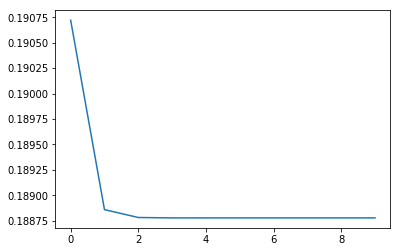

In [109]:
print("\033[1mClassification (Gisette Dataset): \033[0m")
n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)
#lbda = 1. / n ** (0.5)
model = Classification(x_train_c, y_train_c, lbda)

max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) 
stepsize = 2**4 / (max_squared_sum + lbda) 
svrg_class = optimize_svrg(100, 2 * 100, x_train_c, y_train_c, stepsize, model)

Classification (Gisette Dataset): 
After iteration 10 loss is now:  0.8535869229539431
After iteration 20 loss is now:  1.096627936891198
After iteration 30 loss is now:  0.30991544362277773
After iteration 40 loss is now:  0.4761820166845328
After iteration 50 loss is now:  0.21349685226746357
After iteration 60 loss is now:  0.10984562498763148
After iteration 70 loss is now:  0.03613922573783292
After iteration 80 loss is now:  0.08378517655552156
After iteration 90 loss is now:  0.04488530837618876
After iteration 100 loss is now:  0.10883226089021172


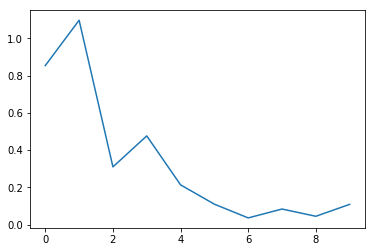

In [110]:
print("\033[1mClassification (Gisette Dataset): \033[0m")
n = x_train_c.shape[0]
#lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)
lbda = 1. / n ** (0.5)
model = Classification(x_train_c, y_train_c, lbda)

max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) 
stepsize = 2**8 / (max_squared_sum + lbda) 
svrg_class = optimize_svrg(100, 2 * 100, x_train_c, y_train_c, stepsize, model)

<a id='comp1'></a>
### SVRG2


In [111]:
print("\033[1mClassification (Gisette Dataset): \033[0m")
n = x_train_c.shape[0]
#lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)
lbda = 1. / n ** (0.5)
model = Classification(x_train_c, y_train_c, lbda)
max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) 
stepsize = 2**8 / (max_squared_sum + lbda) 
svrg_class = optimize_svrg_2(100, 2 * 100, x_train_c, y_train_c, stepsize, model)
# When the stepsize is too important, we encounter an overflow

Classification (Gisette Dataset): 


/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


After iteration 10 loss is now:  nan
After iteration 20 loss is now:  nan


KeyboardInterrupt: 

Classification (Gisette Dataset): 
After iteration 10 loss is now:  0.18363791878024108
After iteration 20 loss is now:  0.1058442036486509
After iteration 30 loss is now:  0.09889008493759201
After iteration 40 loss is now:  0.08781370432493735
After iteration 50 loss is now:  0.07891388945105235


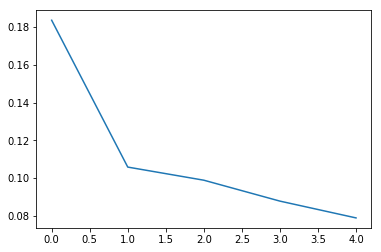

In [112]:
print("\033[1mClassification (Gisette Dataset): \033[0m")
n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)
lbda = 1. / n ** (0.5)
model = Classification(x_train_c, y_train_c, lbda)

max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) 
stepsize = 2**4 / (max_squared_sum + lbda) 
svrg_class = optimize_svrg_2(50, 2 * 50, x_train_c, y_train_c, stepsize, model)

<a id='comp2'></a>
## 5. Regression case : Numerical comparison


<a id='comp1'></a>
### SVRG1


Regression (Cadata Dataset): 
After iteration 10 loss is now:  0.6540426525379853
After iteration 20 loss is now:  0.31731272071685723
After iteration 30 loss is now:  0.19470575031802645
After iteration 40 loss is now:  0.19453472143081812
After iteration 50 loss is now:  0.19453012115551266
After iteration 60 loss is now:  0.19452936781481406
After iteration 70 loss is now:  0.19452935990096448
After iteration 80 loss is now:  0.19452935963668702
After iteration 90 loss is now:  0.19452935962398488
After iteration 100 loss is now:  0.194529359623382


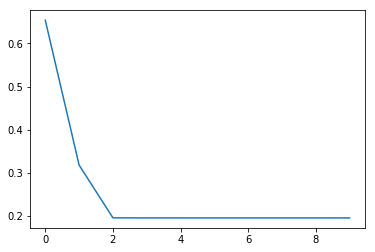

In [118]:
print("\033[1mRegression (Cadata Dataset): \033[0m")
n = x_train_r.shape[0]
#lbda = 1. / n ** (0.5)
lbda = np.max(np.sum(x_train_r ** 2, axis=1))  / (4. * n)
model = Regression(x_train_r, y_train_r, lbda)

max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
stepsize = 2**5 / (max_squared_sum + lbda) 
svrg_reg = optimize_svrg(100, 2 * 100, x_train_r, y_train_r, stepsize, model)

Regression (Cadata Dataset): 
After iteration 10 loss is now:  0.5074349457964101
After iteration 20 loss is now:  0.19031347267677481
After iteration 30 loss is now:  0.4259435918816916
After iteration 40 loss is now:  0.2084902271592318
After iteration 50 loss is now:  0.19211551772916813
After iteration 60 loss is now:  0.18807905366205693
After iteration 70 loss is now:  0.187914955584489
After iteration 80 loss is now:  0.18789738402024933
After iteration 90 loss is now:  0.18789549992469248
After iteration 100 loss is now:  0.18789530153116946


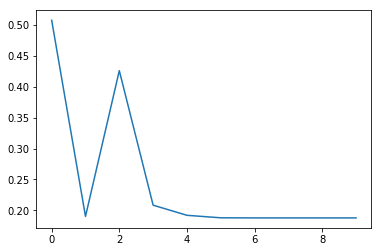

In [119]:
# Test for Regression
print("\033[1mRegression (Cadata Dataset): \033[0m")
n = x_train_r.shape[0]
lbda = 1. / n ** (0.5)
#lbda = np.max(np.sum(x_train_r ** 2, axis=1))  / (4. * n)
model = Regression(x_train_r, y_train_r, lbda)

max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
stepsize = 2**5 / (max_squared_sum + lbda) 
svrg_reg = optimize_svrg(100, 2 * 100, x_train_r, y_train_r, stepsize, model)

<a id='comp1'></a>
### SVRG2


In [131]:
# Test for Regression
print("\033[1mRegression (Cadata Dataset): \033[0m")
n = x_train_r.shape[0]
lbda = 1. / n ** (0.5)
#lbda = np.max(np.sum(x_train_r ** 2, axis=1))  / (4. * n)
model = Regression(x_train_r, y_train_r, lbda)

max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
stepsize = 2**5 / (max_squared_sum + lbda) 
svrg_reg = optimize_svrg_2(100, 2 * 100, x_train_r, y_train_r, stepsize, model)

Regression (Cadata Dataset): 
After iteration 10 loss is now:  6.332699353674544e+230


OverflowError: (34, 'Result too large')